# Paper Figures

1. Setup
1. Import
  - Metadata
  - Trees
    - Divergence tree
    - Timetree
    - Mugration Trees
1. Merge Metadata
1. Export
  - Timetree
  - Divtree
  - Augur and Auspice JSON

---
# 1. Setup

## Modules

In [1]:
import os
from Bio import Phylo, AlignIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec, lines
import scipy
import math
import numpy as np
import geopandas
import datetime
import shapely
import copy
from geopy import distance
import geopy
import cartopy.crs as ccrs
from augur import utils, export_v2

from plot_phylo_functions import *

## Paths

In [2]:
MISSING_DATA=5
JSON_INDENT=2
AUSPICE_PREFIX="plague-phylogeography-projects_main"

In [3]:
project_dir   = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/"
#project_dir   = "/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/"
auspice_remote_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/"


iqtree_dir    = os.path.join(project_dir, "iqtree/all/chromosome/full/filter{}/".format(MISSING_DATA))
lsd_dir       = os.path.join(project_dir, "lsd/all/chromosome/full/filter{}/".format(MISSING_DATA))
mugration_dir = os.path.join(project_dir, "mugration/all/chromosome/full/filter{}/".format(MISSING_DATA))
snippy_dir    = os.path.join(project_dir, "snippy_multi/all/chromosome/full/filter{}/".format(MISSING_DATA))

# ------------------------------------------
# Trees
divtree_path              = iqtree_dir    + "filter-taxa/iqtree.treefile"
timetree_path             = lsd_dir       + "lsd.timetree.nex"
#timetree_path             = lsd_dir       + "lsd.nex"
mugtree_country_path      = mugration_dir + "country.nex".format(MISSING_DATA)
mugtree_province_path     = mugration_dir + "province.nex".format(MISSING_DATA)
mugtree_branch_major_path = mugration_dir + "branch_major.nex".format(MISSING_DATA)
mugtree_branch_minor_path = mugration_dir + "branch_minor.nex".format(MISSING_DATA)
# ------------------------------------------
# Alignment
constant_sites_path   = project_dir + "snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt"
aln_path              = iqtree_dir + "filter-sites/snippy-multi.snps.aln"

# ------------------------------------------
# Metadata
auspice_config_path          = project_dir + "config/auspice_config.json"
metadata_path                = iqtree_dir    + "filter-taxa/metadata.tsv"
mugconf_country_path         = mugration_dir + "country_confidence.csv"
mugstates_country_path       = mugration_dir + "country_states.csv"
mugconf_province_path        = mugration_dir + "province_confidence.csv"
mugstates_province_path      = mugration_dir + "province_states.csv"
mugconf_branch_major_path    = mugration_dir + "branch_major_confidence.csv"
mugstates_branch_major_path  = mugration_dir + "branch_major_states.csv"
mugconf_branch_minor_path    = mugration_dir + "branch_minor_confidence.csv"
mugstates_branch_minor_path  = mugration_dir + "branch_minor_states.csv"
# ------------------------------------------
# Other
xu_2019_path          = project_dir + "figures/xu2019.csv"

# ------------------------------------------
# Output
out_dir = project_dir + "figures/"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

## Variables

In [4]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

NO_DATA_CHAR = "NA"
UNKNOWN_CHAR = "?"
CURRENT_YEAR = datetime.datetime.utcnow().year

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Reference
REF_STRAIN = "CO92"
REF_LAT = "38.7251776"
REF_LON = "-105.607716"
REF_DATE_BP = 1992 - CURRENT_YEAR
REF_BRANCH_MAJOR = "1.ORI"
REF_BRANCH_MINOR = "1.ORI1"
REF_BRANCH_NUMBER = "1"
REF_COUNTRY = "United States of America"
REF_PROVINCE = "Colorado"
REF_CONTINENT = "North America"

# ------------------------------------------
# Plotting
SM_FONT = 4
MED_FONT = 6
LG_FONT = 8
D3_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf" ]

# ------------------------------------------
BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"], 
    "0.PE": ["0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5"],   
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],     
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],    
    "1.ANT": ["1.ANT1"], 
    "1.IN": ["1.IN1","1.IN2","1.IN3"],   
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"],
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ], 
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ], 
    "3.ANT": ["3.ANT1", "3.ANT2" ],     
    "4.ANT": ["4.ANT1" ],           
}

ANCIENT_BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"],  
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],     
}

MUG_ATTRIBUTE_LIST = [
    "branch_major",
    "branch_minor",
    "country",
    "province",
]

---
# 2. Import

## Mugration Confidence Tables

In [5]:
states_files = [mugstates_country_path, mugstates_province_path, mugstates_branch_major_path, mugstates_branch_minor_path]
conf_files = [mugconf_country_path, mugconf_province_path, mugconf_branch_major_path, mugconf_branch_minor_path]

# ----------------------------------------
# Convert character states to numbers
for mugstates,mugconf in zip(states_files, conf_files):
    node_i = 0
    conf_basename = os.path.splitext(mugconf)[0]
    conf_outname = conf_basename + "_tidy.csv"
    i = 0
    state_dict = {}
    with open(mugstates, "r") as infile:
        read_line = infile.readline()
        while read_line:
            split_line = read_line.strip().split(",")
            state = split_line[1]
            if state == "nan":
                state = "NA"
            if state == UNKNOWN_CHAR:
                state_dict[-1] = state
            else:
                state_dict[i] = state
                i += 1
            read_line = infile.readline()
    # Swap first to last place
    final_i = len(state_dict) - 1   
    state_dict[final_i] = "?"
    # Remove old first
    state_dict.pop(-1)

    with open(mugconf, "r") as infile:            
        i = 0
        read_line = infile.readline()
        header = read_line.strip().split(", ")
        header[0] = "name"

        data = ""
        for i in range(0, len(header) - 1):
            char = header[i + 1]
            header[i + 1] = state_dict[i]
        header = ",".join(header)
        read_line = infile.readline()            
        while read_line:
            # Rename internal nodes
            split_line = read_line.split(", ")
            node_name = split_line[0]
            if "NODE" in node_name:
                node_name = "NODE{}".format(node_i)
                node_i += 1
            new_line = ",".join([node_name] + split_line[1:])
            data += new_line
            read_line = infile.readline()
    
    with open(conf_outname, "w") as outfile:
        outfile.write(header + "\n")
        outfile.write(data)

# ----------------------------------------
# Import the tidy files as dataframes
mugconf_country_tidy_path = os.path.splitext(mugconf_country_path)[0] + "_tidy.csv"
mugconf_country_df = pd.read_csv(mugconf_country_tidy_path, sep=',', index_col = 0)

mugconf_province_tidy_path = os.path.splitext(mugconf_province_path)[0] + "_tidy.csv"
mugconf_province_df = pd.read_csv(mugconf_province_tidy_path, sep=',', index_col = 0)

mugconf_branch_major_tidy_path = os.path.splitext(mugconf_branch_major_path)[0] + "_tidy.csv"
mugconf_branch_major_df = pd.read_csv(mugconf_branch_major_tidy_path, sep=',', index_col = 0)

mugconf_branch_minor_tidy_path = os.path.splitext(mugconf_branch_minor_path)[0] + "_tidy.csv"
mugconf_branch_minor_df = pd.read_csv(mugconf_branch_minor_tidy_path, sep=',', index_col = 0)

## Trees

In [6]:
tree_paths = [divtree_path, timetree_path, mugtree_country_path, mugtree_province_path, mugtree_branch_major_path, mugtree_branch_minor_path  ]

for tree_path in tree_paths:
    tree_ext = os.path.splitext(tree_path)[1]
    if tree_ext == ".nwk" or tree_ext == ".newick" or tree_ext == ".treefile":
        tree = Phylo.read(tree_path, "newick")
    elif tree_ext == ".nex" or tree_ext == ".nexus":
        parse_trees = Phylo.parse(tree_path, "nexus")
        for parse_tree in parse_trees:
            clades = [c for c in parse_tree.find_clades()]
            if len(clades) > 1:
                break
        tree = parse_tree
    tree.ladderize(reverse=False)
    
    if tree_path == divtree_path:
        print("divtree:", os.path.basename(divtree_path))
        divtree = tree
    elif tree_path == timetree_path:
        print("timetree:", os.path.basename(timetree_path))        
        timetree = tree    
    elif tree_path == mugtree_country_path:
        print("mugtree_country:", os.path.basename(mugtree_country_path))       
        mugtree_country = tree    
    elif tree_path == mugtree_province_path:
        print("mugtree_province:",os.path.basename(mugtree_province_path))
        mugtree_province = tree  
    elif tree_path == mugtree_branch_major_path:
        print("mugtree_branch_major:",os.path.basename(mugtree_branch_major_path))        
        mugtree_branch_major = tree            
    elif tree_path == mugtree_branch_minor_path:
        print("mugtree_branch_minor:",os.path.basename(mugtree_branch_minor_path))        
        mugtree_branch_minor = tree                
    

divtree: iqtree.treefile
timetree: lsd.timetree.nex
mugtree_country: country.nex
mugtree_province: province.nex
mugtree_branch_major: branch_major.nex
mugtree_branch_minor: branch_minor.nex


### Modern Human Metadata

In [7]:
xu_2019_df = pd.read_csv(xu_2019_path, sep=',')

### Project Genomic Metadata

In [8]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

---
# 3. Merge Metadata

### Tree Data

In [11]:
# Check if they're synchronized
node_i = 0

metadata_df["branch_support_char"] = [""] * len(metadata_df)

for cd,ct,cmc,cmp,cmbmaj, cmbmin in zip(
        divtree.find_clades(), 
        timetree.find_clades(), 
        mugtree_country.find_clades(),
        mugtree_province.find_clades(),
        mugtree_branch_major.find_clades(),    
        mugtree_branch_minor.find_clades(),      
    ):
    # Rename internal nodes
    if not cd.name or "NODE" in cmc.name:
        cd.name = "NODE{}".format(node_i)
        ct.name = "NODE{}".format(node_i)
        cmc.name = "NODE{}".format(node_i) 
        cmp.name = "NODE{}".format(node_i) 
        cmbmaj.name = "NODE{}".format(node_i) 
        cmbmin.name = "NODE{}".format(node_i) 
        node_i += 1
        
    if cd.name != ct.name or cd.name != cmc.name or cd.name != cmp.name:
        print("ERROR. Trees are not synchronized.")
        print(cd.name, ct.name, cmc.name, cmp.name, cmbmaj.name, cmbmin.name)
        break
        
    node_name = cd.name
    
    # node type
    node_type = "internal"
    if cd.is_terminal():
        node_type = "terminal"
    metadata_df.at[node_name, "node_type"] = node_type

    
    # Branch Length
    branch_length = cd.branch_length
    if not branch_length:
        branch_length = 0
    metadata_df.at[node_name, "branch_length"] = branch_length
    # Branch Support
    # Give terminal nodes 100% confidence
    branch_support = cd.confidence
    if cd.is_terminal():
        branch_support = 100
        
    # Internal nodes without confidence can be 0
    elif not cd.confidence:
        branch_support = 0
    metadata_df.at[node_name, "branch_support"] = branch_support
    
    if branch_support >= 95 and not cd.is_terminal():
        branch_support_char = "*"
        metadata_df.at[node_name, "branch_support_char"] = branch_support_char
    
    comment_dict = {}
    # Mugration  Country
    if cmc.comment:
        cmc_comment_dict = parse_comment(cmc.comment)
        for attr in cmc_comment_dict:
            comment_dict["mugration_" + attr] = cmc_comment_dict[attr]
            
    # Mugration  Province
    if cmp.comment:
        cmp_comment_dict = parse_comment(cmp.comment)
        for attr in cmp_comment_dict:
            comment_dict["mugration_" + attr] = cmp_comment_dict[attr]            
            
    # Mugration Branch Major
    if cmbmaj.comment:
        cmbmaj_comment_dict = parse_comment(cmbmaj.comment)
        for attr in cmbmaj_comment_dict:
            comment_dict["mugration_" + attr] = cmbmaj_comment_dict[attr]            
            
    # Mugration Branch Minor
    if cmbmin.comment:
        cmbmin_comment_dict = parse_comment(cmbmin.comment)
        for attr in cmbmin_comment_dict:
            comment_dict["mugration_" + attr] = cmbmin_comment_dict[attr]              

    # Time Tree         
    if ct.comment:
        ct_comment_dict = parse_comment(ct.comment)
        for attr in ct_comment_dict:
            comment_dict["timetree_" + attr] = ct_comment_dict[attr]
            
    for attr in comment_dict:
        metadata_df.at[node_name, attr] = comment_dict[attr]
           
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,node_type,branch_length,branch_support,branch_support_char,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_branch_minor
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,terminal,4.004600e-06,100.0,,-29,NA,NA,United States of America,Colorado,1.ORI,1.ORI1
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923,98,0,47.6222,40.7958,terminal,2.120100e-06,100.0,,-98,NA,NA,Russia,Rostov Oblast,2.MED,2.MED1
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006,15,0,42.4805,85.4633,terminal,0.000000e+00,100.0,,-15,NA,NA,China,Xinjiang,0.ANT,0.ANT1
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,terminal,2.356000e-07,100.0,,-16,NA,NA,China,Xinjiang,0.ANT,0.ANT1
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,terminal,4.711000e-07,100.0,,-16,NA,NA,China,Xinjiang,0.ANT,0.ANT1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.207000e-07,13.0,,-147.759,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1
NODE596,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.356000e-07,13.0,,-147.759,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1
NODE597,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.921000e-07,46.0,,-108.603,"{60.9513,162.9}","{-162.9,-60.9513}",Peru,Cajamarca,1.ORI,1.ORI1


### Add Confidence and Handle Root

In [14]:
df_list = [mugconf_country_df, mugconf_province_df, mugconf_branch_major_df, mugconf_branch_minor_df]
attr_list = ["country", "province", "branch_major", "branch_minor"]

for df,attr in zip(df_list, attr_list):
    for sample in df.index:
        max_state = ""
        max_val = 0        
        for state,val in zip(df.columns, df.loc[sample]):
            if val >= max_val:
                max_val = val
                max_state = state
        metadata_df.at[sample,"mugration_" + attr] = max_state      
        metadata_df.at[sample,"mugration_" + attr + "_confidence"] = round(max_val,2)

display(metadata_df.loc["NODE0"])
#print(list(metadata_df["mugration_branch_minor_confidence"]))

strain                                  NA
date                                    NA
date_bp                                 NA
country                                 NA
province                                NA
                                     ...  
mugration_branch_minor               0.PE7
mugration_country_confidence          0.85
mugration_province_confidence         0.56
mugration_branch_major_confidence      0.5
mugration_branch_minor_confidence     0.31
Name: NODE0, Length: 36, dtype: object

### Lat Lon

In [15]:
latlon_country_df = pd.DataFrame()
latlon_province_df = pd.DataFrame()

df_list = [latlon_country_df, latlon_province_df]
attr_list = ["country", "province"]
conf_df_list = [mugconf_country_df, mugconf_province_df]

# Create a mapping of geo name to lat,lon
for df,attr in zip(df_list, attr_list):
    # Get data
    for rec in metadata_df.iterrows():
        node_name = rec[0]
        name = rec[1][attr]
        lat = rec[1][attr + "_lat"]
        lon = rec[1][attr + "_lon"] 
        
        if name == NO_DATA_CHAR: continue

        if name not in df.index:

            df.at[name, "lat"] = lat
            df.at[name, "lon"] = lon
            df.at[name, "size"] = 1
        else:
            df["size"][name] += 1

#display(latlon_country_df)
#display(latlon_province_df)


# Update lat lon for mugration
for latlon_df, conf_df, attr in zip(df_list, conf_df_list, attr_list):
    for rec in metadata_df.iterrows():
        sample = rec[0]
        name = rec[1]["mugration_" + attr]  
        lat = latlon_df["lat"][name]
        lon = latlon_df["lon"][name]
                
        metadata_df.at[sample, "mugration_" + attr +"_lat"] = lat
        metadata_df.at[sample, "mugration_" + attr +"_lon"] = lon
        
        
# Mapping file for auspice
out_path_latlon = os.path.join(out_dir, "latlon.tsv")

# Countries
with open(out_path_latlon, "w") as outfile:
    for country in latlon_country_df.index:
        lat = str(latlon_country_df["lat"][country])
        lon = str(latlon_country_df["lon"][country])
        outfile.write("country" + "\t" + country + "\t" + lat + "\t" + lon + "\n")
# Provinces
with open(out_path_latlon, "a") as outfile:
    for province in latlon_province_df.index:
        lat = str(latlon_province_df["lat"][province])
        lon = str(latlon_province_df["lon"][province])
        outfile.write("province" + "\t" + province + "\t" + lat + "\t" + lon + "\n")
display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,node_type,branch_length,branch_support,branch_support_char,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_branch_minor,mugration_country_confidence,mugration_province_confidence,mugration_branch_major_confidence,mugration_branch_minor_confidence,mugration_country_lat,mugration_country_lon,mugration_province_lat,mugration_province_lon
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,terminal,4.004600e-06,100.0,,-29,NA,NA,United States of America,Colorado,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,39.783730,-100.445882,38.725178,-105.607716
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923,98,0,47.6222,40.7958,terminal,2.120100e-06,100.0,,-98,NA,NA,Russia,Rostov Oblast,2.MED,2.MED1,1.0,1.00,1.0,1.0,64.686314,97.745306,47.622245,40.795794
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006,15,0,42.4805,85.4633,terminal,0.000000e+00,100.0,,-15,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,terminal,2.356000e-07,100.0,,-16,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,terminal,4.711000e-07,100.0,,-16,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.207000e-07,13.0,,-147.759,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,-6.869970,-75.045851,-6.250000,-78.833333
NODE596,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.356000e-07,13.0,,-147.759,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,-6.869970,-75.045851,-6.250000,-78.833333
NODE597,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.921000e-07,46.0,,-108.603,"{60.9513,162.9}","{-162.9,-60.9513}",Peru,Cajamarca,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,-6.869970,-75.045851,-6.250000,-78.833333


---
# Convert Dataframes to Geopandas

### Modern Human Cases

<GeoAxesSubplot:>

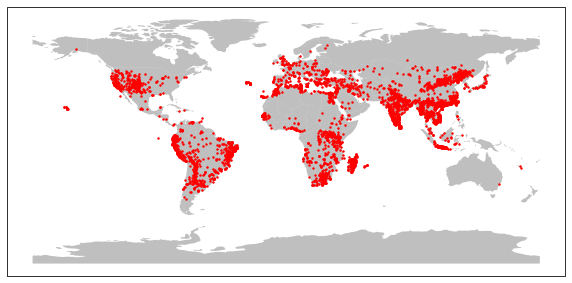

In [16]:
geometry = []

for rec in xu_2019_df.iterrows():
    sample = rec[0]
    lon = float(rec[1]["X"].replace("'",""))
    lat = float(rec[1]["Y"].replace("'",""))
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)

xu_2019_gdf = geopandas.GeoDataFrame(xu_2019_df, crs=CRS, geometry=geometry)

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=(10, 5))
world_polygons.plot(ax=ax, color="grey", alpha=0.5)
xu_2019_gdf.plot(ax=ax, c="red", markersize=2)

### Project Data

<GeoAxesSubplot:>

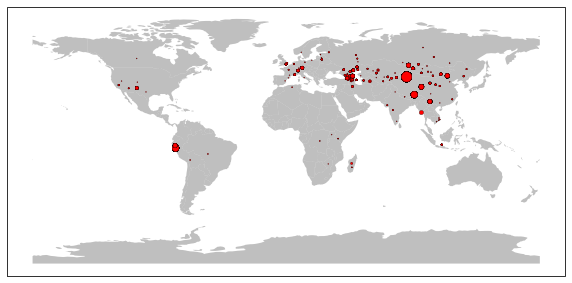

In [17]:
geometry = []

for rec in metadata_df.iterrows():
    sample = rec[0]
    # Terminal nodes use the "lat/lon" attribute        
    if rec[1]["node_type"] == "terminal":  
        province = rec[1]["province"]
        country = rec[1]["country"]
        if province != NO_DATA_CHAR:
            attr = "province"
            name = province
        else:
            attr = "country"
            name = country
        lat = rec[1]["lat"]
        lon = rec[1]["lon"]
    # Internal nodes use mugration province
    else:
        name = rec[1]["mugration_province"]
        lat  = rec[1]["mugration_province_lat"]
        lon  = rec[1]["mugration_province_lon"]     
    
    if attr == "province":
        size = latlon_province_df["size"][name]
    elif attr == "country":
        size = latlon_country_df["size"][name]
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)


metadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)

# Add geometry size
for rec in metadata_gdf.iterrows():
    sample = rec[0]
    name = rec[1]["mugration_" + attr]
    size = latlon_df["size"][name]  
    metadata_gdf.at[sample, "geometry_size"] = size
    


# Test map

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=(10, 5))
world_polygons.plot(ax=ax, color="grey", alpha=0.5)
metadata_gdf.plot(ax=ax, c="red", markersize="geometry_size", ec="black", lw=0.25)

# Colors

Use the full tree for color order

In [18]:
out_path_colors = os.path.join(out_dir, "colors.tsv")

colors_dict = {}

for attr in MUG_ATTRIBUTE_LIST:
    # Create the color map
    attr_key = attr.lower()
    colors_dict[attr_key] = {}
    for t in divtree.get_terminals():
        attr_val = metadata_df[attr][t.name]
        # Remove the letter suffix from branch_minor
        if attr == "branch_minor":
            while attr_val[-1].isalpha():
                attr_val = attr_val[:-1] 
        if attr_val not in colors_dict[attr_key] and attr_val != NO_DATA_CHAR:
            colors_dict[attr_key][attr_val] = {}
            
    # Create the custom color map (pyplot)
    cmap = plt.get_cmap("rainbow", len(colors_dict[attr_key]))
    # Convert the color map to a list of RGB values
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # Convert RGB values to hex colors
    attr_hex = [colors.to_hex(col) for col in cmaplist]
    
    # Assign colors to value
    for attr_val, attr_col in zip(colors_dict[attr_key], attr_hex):
        colors_dict[attr_key][attr_val] = attr_col   
        
    # Add unknown
    colors_dict[attr_key][UNKNOWN_CHAR] = "#969696"

with open(out_path_colors, "w") as outfile:
    for attr_key in colors_dict:
        for attr_val in colors_dict[attr_key]:
            outfile.write(str(attr_key) + "\t" + str(attr_val) + "\t" + str(colors_dict[attr_key][attr_val]) + "\n")

---
# Parse Tree Into Dataframe

In [19]:
x_posns = get_x_positions(divtree)
y_posns = get_y_positions(divtree)

# Initialize 
# Date lower and upper error bars for tips
metadata_gdf["date_lower"] = [NO_DATA_CHAR] * len(metadata_gdf)
metadata_gdf["date_upper"] = [NO_DATA_CHAR] * len(metadata_gdf)
    
for c in divtree.find_clades():
    # ------------------------------------------------------------
    # Coordinates for the divergence tree
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    metadata_gdf.at[c.name, 'divtree_coord_x'] = coord_x
    metadata_gdf.at[c.name, 'divtree_coord_y'] = coord_y
    
    # ------------------------------------------------------------
    # Root to tip distance (same as div x)
    metadata_gdf.at[c.name, "rtt_dist"] = coord_x
    
    # ------------------------------------------------------------
    # Branch Major and Branch Minor and Colors
    branch_minor = metadata_gdf["mugration_branch_minor"][c.name]
    if branch_minor != NO_DATA_CHAR:
        # Remove letters at end
        while branch_minor[-1].isalpha():
            branch_minor = branch_minor[:-1]    
    metadata_gdf.at[c.name, "mugration_branch_minor"] = branch_minor
    branch_major = metadata_gdf["mugration_branch_major"][c.name]
    branch_major_color = colors_dict["branch_major"][branch_major]
    metadata_gdf.at[c.name, "branch_major_color"] = branch_major_color    

    # ------------------------------------------------------------
    # Date lower and upper error bars for tips
    date_mean = metadata_gdf["date_mean"][c.name] 
    if date_mean != NO_DATA_CHAR:
        metadata_gdf.at[c.name, "date_lower"] = date_mean - metadata_gdf["date_err"][c.name]
        metadata_gdf.at[c.name, "date_upper"] = date_mean + metadata_gdf["date_err"][c.name]

x_posns = get_x_positions(timetree)
y_posns = get_y_positions(timetree)


for c in timetree.find_clades():

    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    metadata_gdf.at[c.name, 'timetree_coord_x'] = coord_x
    metadata_gdf.at[c.name, 'timetree_coord_y'] = coord_y
    
    timetree_date = int(float(metadata_gdf["timetree_date"][c.name]))
    timetree_date_calendar = CURRENT_YEAR + timetree_date
    metadata_gdf.at[c.name, 'timetree_date_calendar'] = timetree_date_calendar
    
    timetree_CI_date = metadata_gdf["timetree_CI_date"][c.name]
    if timetree_CI_date == NO_DATA_CHAR:
        timetree_CI_lower_err = 0
        timetree_CI_upper_err = 0
    else:
        timetree_CI_split = [int(float(d)) for d in timetree_CI_date.strip("{}").split(",")]
        timetree_CI_calendar = [CURRENT_YEAR + d for d in timetree_CI_split]
        timetree_CI_lower_err = timetree_date_calendar - timetree_CI_calendar[0]
        timetree_CI_upper_err = timetree_CI_calendar[1] - timetree_date_calendar
    metadata_gdf.at[c.name,"timetree_CI_lower_err"] = timetree_CI_lower_err
    metadata_gdf.at[c.name,"timetree_CI_upper_err"] = timetree_CI_upper_err   

display(metadata_gdf)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,node_type,branch_length,branch_support,branch_support_char,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_branch_minor,mugration_country_confidence,mugration_province_confidence,mugration_branch_major_confidence,mugration_branch_minor_confidence,mugration_country_lat,mugration_country_lon,mugration_province_lat,mugration_province_lon,geometry,geometry_size,date_lower,date_upper,divtree_coord_x,divtree_coord_y,rtt_dist,branch_major_color,timetree_coord_x,timetree_coord_y,timetree_date_calendar,timetree_CI_lower_err,timetree_CI_upper_err
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,terminal,4.004600e-06,100.0,,-29,NA,NA,United States of America,Colorado,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,39.783730,-100.445882,38.725178,-105.607716,POINT (-105.60772 38.72518),1.0,1992,1992,0.000073,509.00,0.000073,#ff0000,6330.17150,509.00,1992.0,0.0,0.0
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923,98,0,47.6222,40.7958,terminal,2.120100e-06,100.0,,-98,NA,NA,Russia,Rostov Oblast,2.MED,2.MED1,1.0,1.00,1.0,1.0,64.686314,97.745306,47.622245,40.795794,POINT (40.79579 47.62225),4.0,1923,1923,0.000073,339.00,0.000073,#b3f396,6261.17070,339.00,1923.0,0.0,0.0
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006,15,0,42.4805,85.4633,terminal,0.000000e+00,100.0,,-15,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346,POINT (85.46335 42.48050),105.0,2006,2006,0.000054,152.00,0.000054,#1996f3,6344.17477,152.00,2006.0,0.0,0.0
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,terminal,2.356000e-07,100.0,,-16,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346,POINT (85.46335 42.48050),105.0,2005,2005,0.000055,171.00,0.000055,#1996f3,6343.17481,171.00,2005.0,0.0,0.0
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,terminal,4.711000e-07,100.0,,-16,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346,POINT (85.46335 42.48050),105.0,2005,2005,0.000055,173.00,0.000055,#1996f3,6343.17471,173.00,2005.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.207000e-07,13.0,,-147.759,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,-6.869970,-75.045851,-6.250000,-78.833333,POINT (-78.83333 -6.25000),18.0,NA,NA,0.000072,598.25,0.000072,#ff0000,6211.41227,598.25,1874.0,34.0,31.0
NODE596,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.356000e-07,13.0,,-147.759,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,-6.869970,-75.045851,-6.250000,-78.833333,POINT (-78.83333 -6.25000),18.0,NA,NA,0.000072,596.75,0.000072,#ff0000,6211.41227,596.75,1874.0,34.0,31.0
NODE597,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA

In [20]:
ancient_gdf = metadata_gdf[metadata_gdf["biosample_comment"].str.contains("Ancient")]
modern_gdf  = metadata_gdf[metadata_gdf["biosample_comment"].str.contains("Modern")]

#display(ancient_gdf)
#display(modern_gdf)

---
# 4. Export

## Timetree

In [21]:
out_timetree = copy.deepcopy(timetree)

for c in out_timetree.find_clades():
    if not c.confidence:
        c.confidence = 0

metadata_to_comment(out_timetree, metadata_gdf)    
out_timetree_path = os.path.join(out_dir, "final.timetree.nex")
Phylo.write(out_timetree, out_timetree_path, "nexus")

1

## Divtree

In [22]:
out_divtree = copy.deepcopy(divtree)

for c in out_divtree.find_clades():
    if not c.confidence:
        c.confidence = 0

metadata_to_comment(out_divtree, metadata_gdf)    
out_divtree_path = os.path.join(out_dir, "final.divtree.nex")
Phylo.write(out_divtree, out_divtree_path, "nexus", format_branch_length="%1.10f")

1

## Augur JSON

In [30]:
display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,node_type,branch_length,branch_support,branch_support_char,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_branch_minor,mugration_country_confidence,mugration_province_confidence,mugration_branch_major_confidence,mugration_branch_minor_confidence,mugration_country_lat,mugration_country_lon,mugration_province_lat,mugration_province_lon,geometry,geometry_size,date_lower,date_upper,divtree_coord_x,divtree_coord_y,rtt_dist,branch_major_color,timetree_coord_x,timetree_coord_y,timetree_date_calendar,timetree_CI_lower_err,timetree_CI_upper_err
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,terminal,4.004600e-06,100.0,,-29,NA,NA,United States of America,Colorado,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,39.783730,-100.445882,38.725178,-105.607716,POINT (-105.60772 38.72518),1.0,1992,1992,0.000073,509.00,0.000073,#ff0000,6330.17150,509.00,1992.0,0.0,0.0
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923,98,0,47.6222,40.7958,terminal,2.120100e-06,100.0,,-98,NA,NA,Russia,Rostov Oblast,2.MED,2.MED1,1.0,1.00,1.0,1.0,64.686314,97.745306,47.622245,40.795794,POINT (40.79579 47.62225),4.0,1923,1923,0.000073,339.00,0.000073,#b3f396,6261.17070,339.00,1923.0,0.0,0.0
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006,15,0,42.4805,85.4633,terminal,0.000000e+00,100.0,,-15,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346,POINT (85.46335 42.48050),105.0,2006,2006,0.000054,152.00,0.000054,#1996f3,6344.17477,152.00,2006.0,0.0,0.0
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,terminal,2.356000e-07,100.0,,-16,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346,POINT (85.46335 42.48050),105.0,2005,2005,0.000055,171.00,0.000055,#1996f3,6343.17481,171.00,2005.0,0.0,0.0
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,terminal,4.711000e-07,100.0,,-16,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346,POINT (85.46335 42.48050),105.0,2005,2005,0.000055,173.00,0.000055,#1996f3,6343.17471,173.00,2005.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.207000e-07,13.0,,-147.759,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,-6.869970,-75.045851,-6.250000,-78.833333,POINT (-78.83333 -6.25000),18.0,NA,NA,0.000072,598.25,0.000072,#ff0000,6211.41227,598.25,1874.0,34.0,31.0
NODE596,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.356000e-07,13.0,,-147.759,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,-6.869970,-75.045851,-6.250000,-78.833333,POINT (-78.83333 -6.25000),18.0,NA,NA,0.000072,596.75,0.000072,#ff0000,6211.41227,596.75,1874.0,34.0,31.0
NODE597,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA

In [126]:
simple_gdf = metadata_gdf[["strain","branch_length","timetree_date_calendar"]]
simple_gdf.rename(columns={"timetree_date_calendar": "timetree_numdate"}, inplace=True)

columns = [
    # Draw Divergence Tree
    "branch_length",
    # Draw Time Tree
    "timetree_date_calendar",
    # Draw Country Map
    "mugration_country",
    "mugration_country_confidence",
    # Draw Province Map
    "mugration_province",
    "mugration_province_confidence",
    # Colors and Filters
    "mugration_branch_major",
    "mugration_branch_major_confidence",
    "mugration_branch_minor",
    "mugration_branch_minor_confidence",   
    "branch_number",
    "branch_support",
    "continent",
    "node_type",
    "geometry_size",
    # Text Description
    "biosample_accession",
    "strain",
    # Tip Dates
    "date_mean",
    "date_err",
    "date_bp_mean",
]

# Edit df
auspice_gdf = metadata_gdf[columns]
auspice_gdf["timetree_num_date_confidence"] = [NO_DATA_CHAR] * len(auspice_gdf)

for attr in MUG_ATTRIBUTE_LIST:
    col = attr + "_conf_category"
    auspice_gdf[col] = ["NA"] * len(auspice_gdf)
    for rec in auspice_gdf.iterrows():
        sample = rec[0]
        conf = auspice_gdf["mugration_" + attr + "_confidence"][sample]
        if conf >= 0.95:
            category = "HIGH"
        elif conf < 0.95:
            category = "LOW"
        auspice_gdf.at[sample, col] = category

for rec in metadata_gdf.iterrows():
    sample = rec[0]
    date = rec[1]["timetree_date_calendar"]
    date_lower = float(date) - rec[1]["timetree_CI_lower_err"]
    date_upper = float(date) + rec[1]["timetree_CI_upper_err"]
    #date_confidence = "{}:{}".format(date_lower, date_upper)
    date_confidence = [date_lower, date_upper]
    auspice_gdf.at[sample,"timetree_num_date_confidence"] = date_confidence
    
auspice_gdf.rename(columns={"timetree_date_calendar": "timetree_num_date"}, inplace=True)

display(auspice_gdf)

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,branch_length,timetree_num_date,mugration_country,mugration_country_confidence,mugration_province,mugration_province_confidence,mugration_branch_major,mugration_branch_major_confidence,mugration_branch_minor,mugration_branch_minor_confidence,branch_number,branch_support,continent,node_type,geometry_size,biosample_accession,strain,date_mean,date_err,date_bp_mean,timetree_num_date_confidence,branch_major_conf_category,branch_minor_conf_category,country_conf_category,province_conf_category
sample,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,4.004600e-06,1992.0,United States of America,1.0,Colorado,1.00,1.ORI,1.0,1.ORI1,1.0,1,100.0,North America,terminal,1.0,SAMEA1705942,CO92,1992,0,29,"[1992.0, 1992.0]",HIGH,HIGH,HIGH,HIGH
GCA_009909635.1_ASM990963v1_genomic,2.120100e-06,1923.0,Russia,1.0,Rostov Oblast,1.00,2.MED,1.0,2.MED1,1.0,2,100.0,Europe,terminal,4.0,SAMN13632815,9_10,1923,0,98,"[1923.0, 1923.0]",HIGH,HIGH,HIGH,HIGH
GCA_009669545.1_ASM966954v1_genomic,0.000000e+00,2006.0,China,1.0,Xinjiang,1.00,0.ANT,1.0,0.ANT1,1.0,0,100.0,Asia,terminal,105.0,SAMN07722925,42126,2006,0,15,"[2006.0, 2006.0]",HIGH,HIGH,HIGH,HIGH
GCA_009669555.1_ASM966955v1_genomic,2.356000e-07,2005.0,China,1.0,Xinjiang,1.00,0.ANT,1.0,0.ANT1,1.0,0,100.0,Asia,terminal,105.0,SAMN07722924,42123,2005,0,16,"[2005.0, 2005.0]",HIGH,HIGH,HIGH,HIGH
GCA_009669565.1_ASM966956v1_genomic,4.711000e-07,2005.0,China,1.0,Xinjiang,1.00,0.ANT,1.0,0.ANT1,1.0,0,100.0,Asia,terminal,105.0,SAMN07722923,42118,2005,0,16,"[2005.0, 2005.0]",HIGH,HIGH,HIGH,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,2.207000e-07,1874.0,Peru,1.0,Cajamarca,1.00,1.ORI,1.0,1.ORI1,1.0,NA,13.0,NA,internal,18.0,NA,NA,NA,NA,NA,"[1840.0, 1905.0]",HIGH,HIGH,HIGH,HIGH
NODE596,2.356000e-07,1874.0,Peru,1.0,Cajamarca,1.00,1.ORI,1.0,1.ORI1,1.0,NA,13.0,NA,internal,18.0,NA,NA,NA,NA,NA,"[1840.0, 1905.0]",HIGH,HIGH,HIGH,HIGH
NODE597,2.921000e-07,1913.0,Peru,1.0,Cajamarca,1.00,1.ORI,1.0,1.ORI1,1.0,NA,46.0,NA,internal,18.0,NA,NA,NA,NA,NA,"[1859.0, 1961.0]",HIGH,HIGH,HIGH,HIGH


In [128]:
#import sys, importlib
#importlib.reload(sys.modules['plot_phylo_functions'])
#from plot_phylo_functions import augur_export,auspice_export

augur_dict = augur_export(
    tree_path=out_divtree_path, 
    aln_path=aln_path, 
    #tree=timetree,     
    tree=divtree, 
    tree_df=auspice_gdf, 
    color_keyword_exclude=["geometry"],
    #color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "branch_number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

out_path_augur_json = os.path.join(out_dir, "augur_All.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

auspice_dict = auspice_export(
    #tree=timetree, 
    tree=divtree,
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=out_path_colors,
    auspice_latlons_path=out_path_latlon, 
    )

label_col = list(auspice_gdf.columns)

# Recursively add branch attrs
branch_attributes(
    tree_dict=auspice_dict["tree"], 
    sub_dict=auspice_dict["tree"], 
    df=auspice_gdf,
    label_col=label_col,
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(out_dir, "auspice_All.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.\n")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir, AUSPICE_PREFIX + "_All.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.\n")

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'branch_length': 4.0046e-06, 'num_date': 1992.0, 'country': 'United States of America', 'country_confidence': {'United States of America': 1.0}, 'province': 'Colorado', 'province_confidence': {'Colorado': 1.0}, 'branch_major': '1.ORI', 'branch_major_confidence': {'1.ORI': 1.0}, 'branch_minor': '1.ORI1', 'branch_minor_confidence': {'1.ORI1': 1.0}, 'branch_number': '1.0', 'branch_support': 100.0, 'continent': 'North America', 'node_type': 'terminal', 'biosample_accession': 'SAMEA1705942', 'strain': 'CO92', 'date_mean': 1992.0, 'date_err': 0.0, 'date_bp_mean': 29.0, 'num_date_confidence': [1992.0, 1992.0], 'branch_major_conf_category': 'HIGH', 'branch_minor_conf_category': 'HIGH', 'country_conf_category': 'HIGH', 'province_conf_category': 'HIGH'}
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/ma

## Auspice Subtrees

In [129]:
for branch in BRANCH_LIST:
    print(branch)
    timetree_copy = copy.deepcopy(timetree)
    
    # Create the subtree df
    subtree_df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[branch])]

    subtree_df.sort_values("timetree_coord_y", inplace=True)
    subtree_tips = subtree_df[subtree_df["node_type"] == "terminal"]
    subtree_internals = subtree_df[subtree_df["node_type"] == "internal"]

    subtree = extract_subtree(
        tree=timetree_copy, 
        tips=list(subtree_tips.index), 
        df=metadata_gdf, 
        color_branches=False)
    
    metadata_to_comment(subtree, metadata_gdf)   

    # Export subtree
    out_subtree_path = os.path.join(out_dir, "{}.nex".format(branch))
    Phylo.write(subtree, out_subtree_path, "nexus")

    #fig, ax = plt.subplots(1)
    #Phylo.draw(subtree, axes=ax, show_confidence=False, label_func = lambda x: '', do_show=False)
    
    augur_dict = augur_export(
        tree_path=out_subtree_path, 
        aln_path=aln_path,  
        tree=subtree, 
        tree_df=auspice_gdf, 
        color_keyword_exclude=["geometry"],
        type_convert = {
            "branch_number" : (lambda x : str(x))
        },
    ) 
        
    out_path_augur_json = os.path.join(out_dir, "augur_{}.json".format(branch) )
    utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)
    
    auspice_dict = auspice_export(
        tree=subtree,
        augur_json_paths=[out_path_augur_json], 
        auspice_config_path=auspice_config_path, 
        auspice_colors_path=out_path_colors,
        auspice_latlons_path=out_path_latlon, 
        )    
    
    label_col = list(auspice_gdf.columns)

    # Recursively add branch attrs
    branch_attributes(
        tree_dict=auspice_dict["tree"], 
        sub_dict=auspice_dict["tree"], 
        df=auspice_gdf,
        label_col=label_col,
        )    
    
    # Write outputs - For Local Rendering
    out_path_auspice_local_json = os.path.join(out_dir, "auspice_{}.json".format(branch) )
    utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
    export_v2.validate_data_json(out_path_auspice_local_json)
    print("Validation successful for local JSON.\n")

    # Write outputs - For Remote Rendering
    out_path_auspice_remote_json = os.path.join(auspice_remote_dir, AUSPICE_PREFIX + "_{}.json".format(branch) )
    utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
    export_v2.validate_data_json(out_path_auspice_remote_json)
    print("Validation successful for remote JSON.\n")    

"""
# Terminal df
subtree_tips = subtree_df[subtree_df["node_type"] == "terminal"]

# Internal df
subtree_internals = subtree_df[subtree_df["node_type"] == "internal"]
timetree_copy = copy.deepcopy(timetree)
subtree = extract_subtree(tree=timetree_copy, tips=list(subtree_tips.index), df=metadata_gdf, color_branches=False)"""

0.PRE
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.


DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_0.PRE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_0.PRE.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_0.PRE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_0.PRE.json' succeeded.
Validation successful for remote JSON.

0.ANT4
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_0.ANT4.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_0.ANT4.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_0.ANT4.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_0.ANT4.json' succeeded.
Validation successful for remote JSON.

0.PE



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_0.PE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_0.PE.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_0.PE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_0.PE.json' succeeded.
Validation successful for remote JSON.

0.ANT



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_0.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_0.ANT.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_0.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_0.ANT.json' succeeded.
Validation successful for remote JSON.

1.PRE



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_1.PRE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_1.PRE.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_1.PRE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_1.PRE.json' succeeded.
Validation successful for remote JSON.

1.ANT



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_1.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_1.ANT.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_1.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_1.ANT.json' succeeded.
Validation successful for remote JSON.

1.IN
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_1.ORI.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_1.ORI.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_1.ORI.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_1.ORI.json' succeeded.
Validation successful for remote JSON.

2.ANT



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_2.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_2.ANT.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_2.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_2.ANT.json' succeeded.
Validation successful for remote JSON.

2.MED



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_2.MED.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_2.MED.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_2.MED.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_2.MED.json' succeeded.
Validation successful for remote JSON.

3.ANT
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_confi


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_3.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_3.ANT.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_3.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_3.ANT.json' succeeded.
Validation successful for remote JSON.

4.ANT



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_4.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/figures/auspice_4.ANT.json' succeeded.
Validation successful for local JSON.

Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_4.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/auspice/plague-phylogeography-projects_main_4.ANT.json' succeeded.
Validation successful for remote JSON.



'\n# Terminal df\nsubtree_tips = subtree_df[subtree_df["node_type"] == "terminal"]\n\n# Internal df\nsubtree_internals = subtree_df[subtree_df["node_type"] == "internal"]\ntimetree_copy = copy.deepcopy(timetree)\nsubtree = extract_subtree(tree=timetree_copy, tips=list(subtree_tips.index), df=metadata_gdf, color_branches=False)'

---
# 5. Plot RTT

## All

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



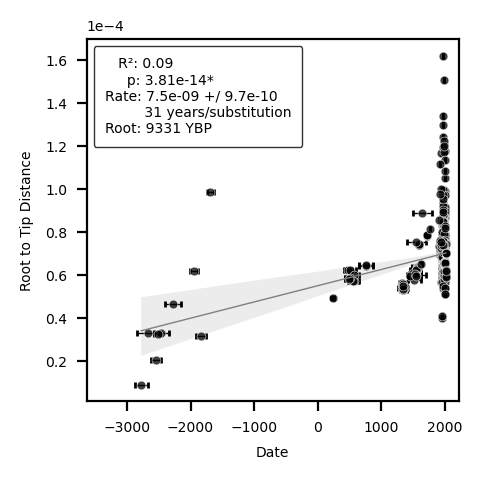

In [52]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

geo_dist_all = []
genetic_dist_all = []

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

df = metadata_gdf[(metadata_gdf["node_type"] == "terminal") & (metadata_gdf["date_mean"] != NO_DATA_CHAR)]
reg_x = "date_mean"
reg_y = "rtt_dist"
reg_err = "date_err"

# -----------------------
# Regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(df[reg_x]),list(df[reg_y]))
r2 = r_value * r_value    
y_intercept = CURRENT_YEAR - (0 - intercept)/slope
p_sig = ""
p_thresh = 0.05    
if p_value < p_thresh:
    p_sig = "*"

mut_per_year = SEQ_LEN * slope
year_per_mut = 1 / mut_per_year
reg_dict = {
    "slope": slope,
    "x_intercept" : intercept,
    "y_intercept" : y_intercept,
    "p_value" : p_value,
    "p_sig" : p_sig,
    "year_per_mut" : year_per_mut
}

sns.regplot(
    ax=ax,
    data=df, 
    x=list(df[reg_x]), 
    y=list(df[reg_y]), 
    #robust=True,
    ci=95,
    scatter_kws={"s": 0},
    line_kws={"linewidth" : 0.5},
    color="grey",
    #color=df["branch_major_color"][0],
    label=(
    "   R²: {}".format(round(r2,2))
    + "\n     p: {:.2e}{}".format(p_value, p_sig)
    + "\nRate: {:.2} +/ {:.2}".format(slope, std_err)  
    + "\n         {} years/substitution".format(round(year_per_mut))
    + "\nRoot: {} YBP".format(round(y_intercept))                
    )
)

ax.errorbar(
    data=df, 
    x=reg_x, 
    y=reg_y, 
    xerr=reg_err,
    yerr=None,
    ls='none',
    c = "black",  
    capsize=1,
    label=None,
    zorder=1,
    lw=0.5,
    )  

sns.scatterplot(
    ax=ax,
    data=df, 
    x=reg_x, 
    y=reg_y, 
    s=10,    
    ec = "white", 
    color="black",
    alpha=0.75,
    zorder=2,
) 

    
# Set xlimits
xlim = ax.get_xlim()
x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
if new_xlim[1] > CURRENT_YEAR:
    new_xlim = [new_xlim[0], CURRENT_YEAR + 200]
ax.set_xlim(new_xlim)
    
ax.set_ylabel("Root to Tip Distance")
ax.set_xlabel("Date")    
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 

# Format and position legend
legend = ax.legend(
    borderpad=0.8, 
    handletextpad=-2, 
    edgecolor="black", 
    #bbox_to_anchor=(0.5, -0.30), 
    #loc='center',
    fontsize=FONTSIZE,
)
frame = legend.get_frame().set_linewidth(0.5)

out_path = os.path.join(out_dir, "rtt_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Clades

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Branch: 0.PRE
Branch: 0.ANT4
Branch: 0.PE
Branch: 0.ANT
Branch: 1.PRE
Branch: 1.ANT
Branch: 1.IN
Branch: 1.ORI
Branch: 2.ANT
Branch: 2.MED
Branch: 3.ANT
Branch: 4.ANT


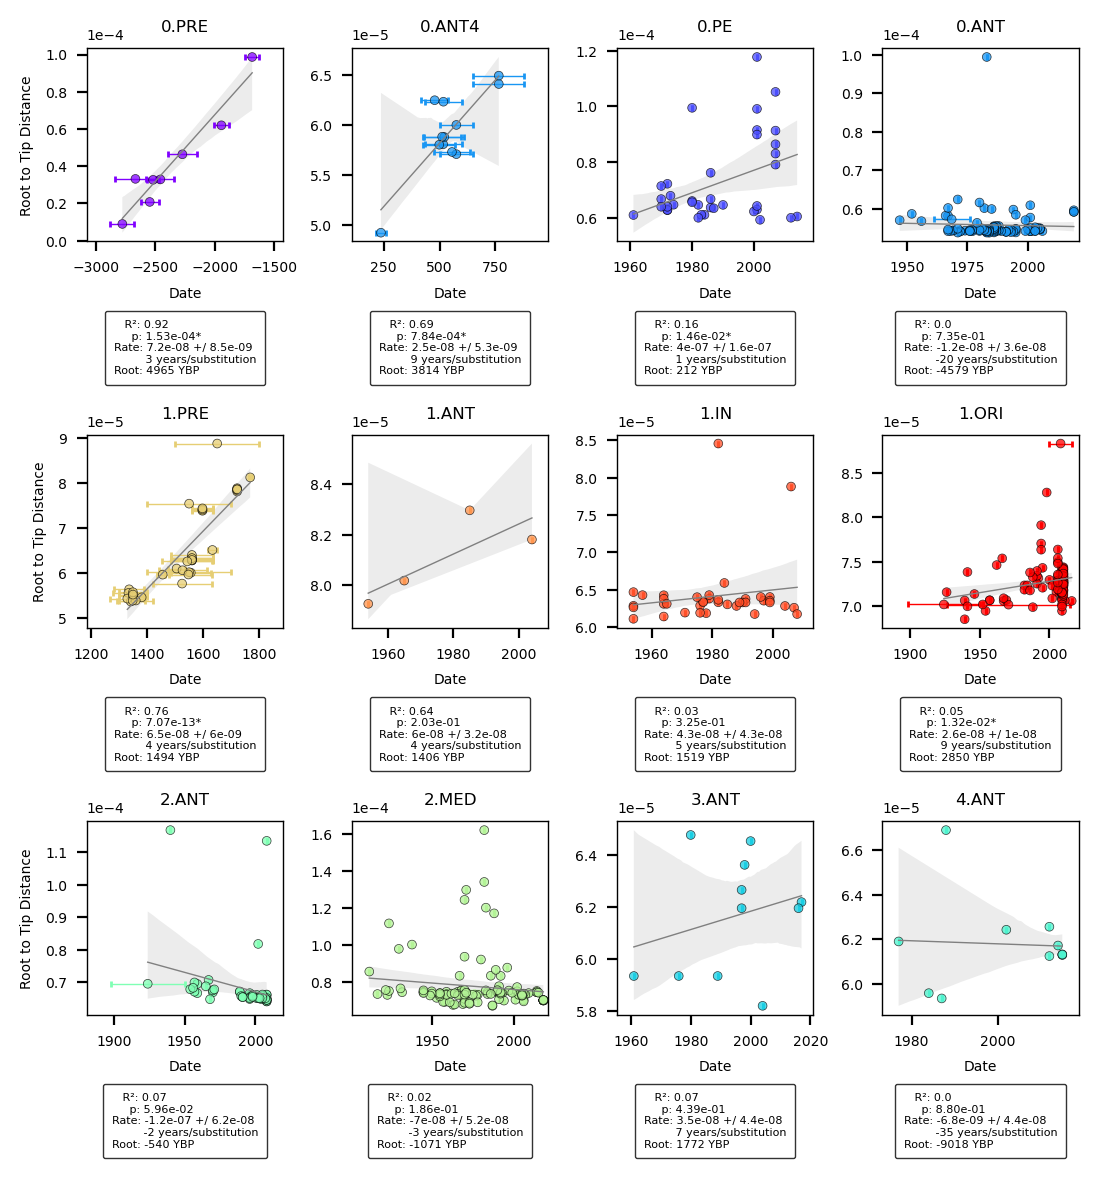

In [53]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

reg_x = "date_mean"
reg_y = "rtt_dist"
reg_err = "date_err"

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=1)

i_row = 0
i_col = 0

for label in BRANCH_LIST:
    print("Branch:", label)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]  
    # If no records for this branch, continue
    if len(df) < 2: continue
    # -----------------------
    # Regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(df[reg_x]),list(df[reg_y]))
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    p_thresh = 0.05    
    if p_value < p_thresh:
        p_sig = "*"

    mut_per_year = SEQ_LEN * slope
    year_per_mut = 1 / mut_per_year
    
    reg_dict = {
        "slope": slope,
        "x_intercept" : intercept,
        "y_intercept" : y_intercept,
        "p_value" : p_value,
        "p_sig" : p_sig,
        "year_per_mut" : year_per_mut
    }
              
    sns.regplot(
        ax=ax,
        data=df, 
        x=list(df[reg_x]), 
        y=list(df[reg_y]), 
        #robust=True,
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.5},
        color="grey",
        #color=df["branch_major_color"][0],
        label=(
        "   R²: {}".format(round(r2,2))
        + "\n     p: {:.2e}{}".format(p_value, p_sig)
        + "\nRate: {:.2} +/ {:.2}".format(slope, std_err)  
        + "\n         {} years/substitution".format(round(year_per_mut))
        + "\nRoot: {} YBP".format(round(y_intercept))                
        )
    )
    
    ax.errorbar(
        data=df, 
        x="date_mean",
        y="rtt_dist", 
        xerr="date_err",
        yerr=None,
        ls='none',
        c = df["branch_major_color"][0],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )  
    
    sns.scatterplot(
        ax=ax,
        data=df, 
        x="date_mean",
        s=10,
        y="rtt_dist", 
        c = df["branch_major_color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )    
    
    # Set xlimits
    xlim = ax.get_xlim()
    x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
    new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
    if new_xlim[1] > CURRENT_YEAR:
        new_xlim = [new_xlim[0], CURRENT_YEAR]
    ax.set_xlim(new_xlim)

    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.55), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Root to Tip Distance")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
        
    
out_path = os.path.join(out_dir, "rtt_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

# Tip Dating

In [ ]:
"""# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

reg_x = "date_mean"
reg_y = "rtt_dist"
reg_err = "date_err"

nrow=3
ncol=3

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=0.35)
#fig.subplots_adjust(wspace=0.35, hspace=0.85)

for row in axes:
    for ax in row:
        for spine in ax.spines:
            ax.spines[spine].set_linewidth(0.5) 

i_row = 0
i_col = 0

for label in ANCIENT_BRANCH_LIST:
    print("Branch:", label)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    if len(df) < 2: continue
    
    # -----------------------
    # Regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(df[reg_x]),list(df[reg_y]))
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    p_thresh = 0.05    
    if p_value < p_thresh:
        p_sig = "*"
        
    mut_per_year = SEQ_LEN * slope
    year_per_mut = 1 / mut_per_year
    
    reg_dict = {
        "slope": slope,
        "x_intercept" : intercept,
        "y_intercept" : y_intercept,
        "p_value" : p_value,
        "p_sig" : p_sig,
        "year_per_mut" : year_per_mut
    }
    
              
    sns.regplot(
        ax=ax,
        data=df, 
        x=list(df[reg_x]),
        y=list(df[reg_y]),
        #robust=True,
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.5},
        color="grey",
        #color=df["branch_major_color"][0],
        label=(
        "   R²: {}".format(round(r2,2))
        + "\n     p: {:.2e}{}".format(p_value, p_sig)
        + "\nRate: {:.2} +/ {:.2}".format(slope, std_err)  
        + "\n         {} years/substitution".format(round(year_per_mut))
        + "\nRoot: {} YBP".format(round(y_intercept))                
        )
    )
    
    ax.errorbar(
        data=df, 
        x="date_mean",
        y="rtt_dist", 
        xerr="date_err",
        yerr=None,
        ls='none',
        c = df["branch_major_color"][0],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )  
    
    sns.scatterplot(
        ax=ax,
        data=df, 
        x="date_mean",
        s=10,
        y="rtt_dist", 
        c = df["branch_major_color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )    
    
        
    # Set xlimits
    xlim = ax.get_xlim()
    x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
    new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
    if new_xlim[1] > CURRENT_YEAR:
        new_xlim = [new_xlim[0], CURRENT_YEAR]
    ax.set_xlim(new_xlim)

    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.55), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)
    ax.get_legend().remove()
    
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Root to Tip Distance")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
      
            
    # Now predicted values
    i_row += 1
    ax = axes[i_row][i_col]    
    
    date_diffs = []
    for date_mean, rtt_dist in zip(df["date_mean"], df["rtt_dist"]):
        pred_date = (rtt_dist - reg_dict["x_intercept"]) / reg_dict["slope"]
        date_diff = pred_date - date_mean
        date_diffs.append(date_diff)
        
    sns.kdeplot(
       date_diffs,
       ax=ax,
       fill=True, 
       common_norm=True,
       alpha=0.5, 
       linewidth=1,
       bw_adjust=0.25,
       color=df["branch_major_color"][0],
    )
    
    if i_col == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Regression Date - Actual Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  
    ax.set_xlim(-300,300)    

    # ---------------------------------------------------------------
    # Diff based on LSD2 estimate
    i_row += 1
    ax = axes[i_row][i_col]  
    
    date_diffs = []
    for date_mean, timetree_date in zip(df["date_mean"], df["timetree_date"]):
        date_est = CURRENT_YEAR + float(timetree_date)
        date_diff = date_est - date_mean
        date_diffs.append(date_diff)  
        
    sns.kdeplot(
       date_diffs,
       ax=ax,
       fill=True, 
       common_norm=True,
       alpha=0.5, 
       linewidth=1,
       bw_adjust=0.25,
       color=df["branch_major_color"][0],
    )
    
    if i_col == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("LSD2 Date - Actual Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))   
    ax.set_xlim(-300,300)
    
    # Update axis
    i_row = 0
    i_col += 1


out_path = os.path.join(out_dir, "tip-dating")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""

In [ ]:
print("All:", len(metadata_gdf[metadata_gdf["node_type"] == "terminal"]))
print("Ancient:",len(ancient_gdf), len(ancient_gdf) / len(metadata_gdf))
print("Modern:",len(modern_gdf), len(modern_gdf) / len(metadata_gdf))

In [ ]:
"""TARGET_RES = [1280, 720]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
fig, ax = plt.subplots(1, dpi=DPI, figsize=FIGSIZE)

rtt_dist_ln = []
for rtt_dist in df["rtt_dist"]:
    rtt_dist_ln.append(math.log(rtt_dist))

sns.kdeplot(
   rtt_dist_ln,
    ax=ax,
)"""

## 1.PRE Subtree

In [54]:
# Create the subtree df
subtree_df = metadata_gdf[metadata_gdf["mugration_branch_major"] == "1.PRE"]
subtree_df.sort_values("timetree_coord_y", inplace=True)

# Terminal df
subtree_tips = subtree_df[subtree_df["node_type"] == "terminal"]

# Internal df
subtree_internals = subtree_df[subtree_df["node_type"] == "internal"]
timetree_copy = copy.deepcopy(timetree)
subtree = extract_subtree(tree=timetree_copy, tips=list(subtree_tips.index), df=metadata_gdf, color_branches=False)

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


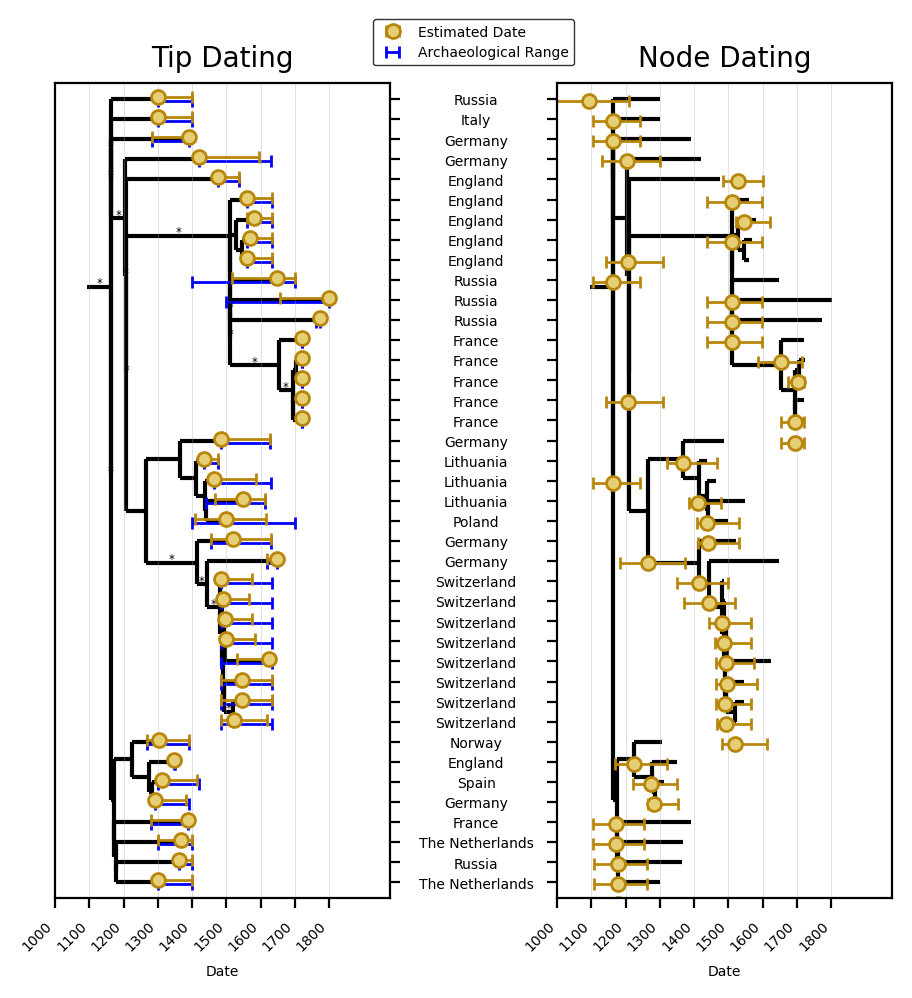

In [55]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1080, 1080]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

#fig, axes = plt.subplots(1,figsize=FIGSIZE, dpi=DPI, sharey=True)
#ax_tree=axes

fig, axes = plt.subplots(1,2,figsize=FIGSIZE, dpi=DPI, sharey=True)
fig.subplots_adjust(wspace=0.5)  
        
##############################################################
# TIPS
ax=axes[0]

# Give the numdate attribute
for c in subtree.find_clades():
    c.numdate = metadata_gdf["timetree_date_calendar"][c.name]

Phylo.draw(subtree,
           axes=ax,
             show_confidence=False, 
             label_func = lambda x: '',
             #label_func = lambda x: "  {}".format(metadata_gdf["country"][x.name]) if x.is_terminal() else '',
             do_show=False,
             branch_labels = lambda x: (
                 '*' if not x.is_terminal() and metadata_gdf["branch_support"][x.name] >= 95
                 else ''),
            )


ax.set_ylabel("")
ax.set_yticks([i for i in range(1,len(subtree_tips)+1)])
ax.set_yticklabels(list(subtree_tips["country"]), fontsize=FONTSIZE, ha="center",position=(1.2,0))
ax.yaxis.tick_right()


# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=subtree, step=100)
# Set the new tick locations and labels
# Leave out last one
ax.set_xticks(ticks_dict["tick_locs"][:])
ax.set_xticklabels(ticks_dict["tick_labels"][:], ROTATION=45, ha="right")
date_to_x = ticks_dict["tick_locs"][0] - float(ticks_dict["tick_labels"][0])

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"][:]:
    ax.axvline(x=loc, color="darkgrey", alpha=0.5, lw=0.25)
        


# --------------------------------------------
# Tip Locations
timetree_date_err = [[],[]]
for lower,upper in zip(subtree_tips["timetree_CI_lower_err"], subtree_tips["timetree_CI_upper_err"] ):
    timetree_date_err[0].append(lower)
    timetree_date_err[1].append(upper)
    
ax.errorbar(
    data=subtree_tips, 
    x=[float(d) + date_to_x for d in subtree_tips["timetree_date_calendar"]],
    y=[i-0.1 for i in range(1,len(subtree_tips)+1,1)], 
    yerr=None, 
    xerr=timetree_date_err,
    ls='none',  
    #c = "black",  
    capsize=2,
    label="Estimated Date",
    zorder=3,
    lw=1, 
    color="darkgoldenrod",
    marker="o",
    markersize=5,
    markerfacecolor=subtree_tips["branch_major_color"][0], 
    
)

ax.errorbar(
    data=subtree_tips, 
    x=[d + date_to_x for d in subtree_tips["date_mean"]],
    y=[i+0.1 for i in range(1,len(subtree_tips)+1,1)], 
    yerr=None, 
    xerr="date_err",
    ls='none',  
    #c = "black",  
    capsize=2,
    label="Archaeological Range",
    zorder=2,
    lw=1, 
    color="blue", 
    #c=subtree_tips["branch_major_color"][0],    
)

ax.set_title("Tip Dating", fontsize=FONTSIZE * 2)
ax.set_xlabel("Date")

legend = ax.legend(fontsize=FONTSIZE, loc="center", bbox_to_anchor=(1.25,1.05), edgecolor="black")
legend.get_frame().set_linewidth(0.5)

##############################################################
# INTERNAL AXIS
ax=axes[1]
Phylo.draw(subtree,
           axes=ax,
             show_confidence=False, 
             label_func = lambda x: '',
             #label_func = lambda x: "  {}".format(metadata_gdf["country"][x.name]) if x.is_terminal() else '',
             #label_func = lambda x: x.name if not x.is_terminal() else '',
             do_show=False,
            )
# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=subtree, step=100)
# Set the new tick locations and labels
# Leave out last one
ax.set_xticks(ticks_dict["tick_locs"][:])
ax.set_xticklabels(ticks_dict["tick_labels"][:], ROTATION=45, ha="right")
date_to_x = ticks_dict["tick_locs"][0] - float(ticks_dict["tick_labels"][0])

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"][:]:
    ax.axvline(x=loc, color="darkgrey", alpha=0.5, lw=0.25)
    
ax.set_title("Node Dating", fontsize=FONTSIZE * 2)
ax.set_xlabel("Date")

# --------------------------------------------
# Interanl Locations
timetree_date_err = [[],[]]
for lower,upper in zip(subtree_internals["timetree_CI_lower_err"], subtree_internals["timetree_CI_upper_err"] ):
    timetree_date_err[0].append(lower)
    timetree_date_err[1].append(upper)
    
ax.errorbar(
    data=subtree_internals, 
    x=[d + date_to_x for d in subtree_internals["timetree_date_calendar"]],
    y=[i+0.1 for i in range(1,len(subtree_internals)+1,1)], 
    yerr=None, 
    xerr=timetree_date_err,
    ls='none',  
    #c = "black",  
    capsize=2,
    zorder=2,
    lw=1, 
    color="darkgoldenrod",
    marker="o",
    markersize=5,
    markerfacecolor=subtree_tips["branch_major_color"][0], 
)

ax.set_ylabel("")

out_path = os.path.join(out_dir, "dating_1.PRE")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

In [ ]:
"""       
#----------------------------------------------------
# Actual Date
ax_plot.errorbar(
    data=subtree_tips, 
    x="date_mean",  
    y=[float(i) for i in range(1,len(subtree_tips)+1,1)],  
    #y=[i for i in range(len(subtree_tips)+1,1,-1)],    
    yerr=None, 
    xerr="date_err",
    ls='none',  
    #c = "black",  
    capsize=1,
    label="Archaeological Date",
    zorder=1,
    lw=0.5, 
    color="black", 
    #c=subtree_tips["branch_major_color"][0],    
)


sns.scatterplot(
    ax=ax,
    data=subtree_tips,
    x="date_mean", 
    #y="timetree_coord_y", 
    y=[i for i in range(0,len(subtree_tips)*data_spacing,data_spacing)],
    color="black",
    #hue=subtree_tips["country"],
    #c=subtree_tips["branch_major_color"],
    s=5)

#------------------------------------------------------

timetree_date_err = [[],[]]

for lower,upper in zip(subtree_tips["timetree_CI_lower_err"], subtree_tips["timetree_CI_upper_err"] ):
    timetree_date_err[0].append(lower)
    timetree_date_err[1].append(upper)

sns.scatterplot(
    ax=ax,
    data=subtree_tips,
    x="timetree_date_calendar",
    #y="timetree_coord_y", 
    y=[i for i in range(3,len(subtree_tips)*data_spacing,data_spacing)],    
    color="red",
    #hue=subtree_tips["country"],
    #c=subtree_tips["branch_major_color"],
    s=10) 


ax.errorbar(
    data=subtree_tips, 
    x="timetree_date_calendar", 
    #y=[i for i in range(4,len(subtree_tips)*data_spacing,data_spacing)],
    y="timetree_coord_y",
    yerr=None, 
    xerr=timetree_date_err,
    ls='none',  
    #c = "black",  
    capsize=1,
    label="Estimated Date",
    zorder=1,
    lw=0.5, 
    color="red", 
    #c=subtree_tips["branch_major_color"][0],    
)


ax.set_ylabel("")
ax.set_yticklabels(list(subtree_tips["country"]), fontsize=FONTSIZE)
ax.set_xlabel("Date")
ax.set_title("Leave-One-Out Tip Dating (1.PRE)")
ax.legend(bbox_to_anchor=(1,1), fontsize=FONTSIZE)

#display(subtree_tips)

out_path = os.path.join(out_dir, "leave-one-out")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""

In [ ]:
display(subtree_tips)

---
# Geography

## Isolation By Distance

### Prep Data

In [121]:
ibd_dict = {}

for label in BRANCH_LIST:
    print("Label:", label)    
    ibd_dict[label] = {"geo_dist" : [], "genetic_dist" : []}
    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    
    i_compare = 0
    i = 0
    for sample1 in df.index:
        geom1 = df["geometry"][sample1]
        coord1 = (geom1.y, geom1.x)  
        for sample2 in df.index[i_compare:]:
            if sample1 == sample2: continue
            geom2 = df["geometry"][sample2]
            coord2 = (geom2.y, geom2.x)
            geo_dist = geopy.distance.great_circle(coord1, coord2).km
            genetic_dist = divtree.distance(sample1, sample2)

            ibd_dict[label]["geo_dist"].append(geo_dist)
            ibd_dict[label]["genetic_dist"].append(genetic_dist)
        i_compare += 1

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Label: 0.PRE
Label: 0.ANT4
Label: 0.PE
Label: 0.ANT
Label: 1.PRE
Label: 1.ANT
Label: 1.IN
Label: 1.ORI
Label: 2.ANT
Label: 2.MED
Label: 3.ANT
Label: 4.ANT


### All

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



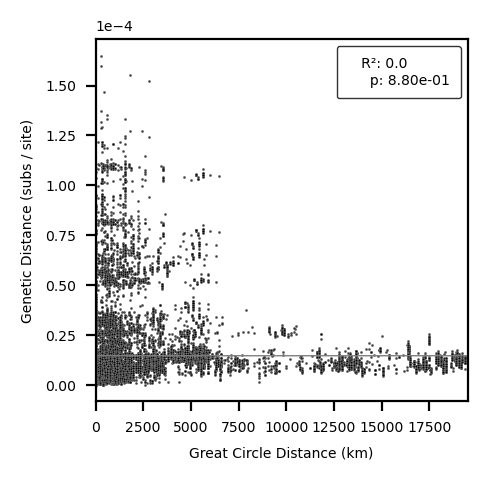

In [130]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

geo_dist_all = []
genetic_dist_all = []

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

for branch in ibd_dict:
    geo_dist_all = geo_dist_all + ibd_dict[branch]["geo_dist"]
    genetic_dist_all = genetic_dist_all + ibd_dict[branch]["genetic_dist"]

sns.regplot(
    ax=ax,
    x=geo_dist_all,
    y=genetic_dist_all,
    ci=95,
    scatter_kws={"s": 0},
    color="grey",
    line_kws={"linewidth":0.5},
    label=(
    "   R²: {}".format(round(r2,2))
    + "\n     p: {:.2e}{}".format(p_value, p_sig)             
    )
)
    
sns.scatterplot(
    ax=ax,
    x=geo_dist_all,
    y=genetic_dist_all,
    s=1,
    ec = "white", 
    color="black",
    alpha=0.75,
    zorder=2,
)

# Format and position legend
legend = ax.legend(
    borderpad=0.8, 
    handletextpad=-2, 
    edgecolor="black", 
    #bbox_to_anchor=(0.5, -0.30), 
    #loc='center',
    fontsize=FONTSIZE,
)
frame = legend.get_frame().set_linewidth(0.5)

ax.set_ylabel("Genetic Distance (subs / site)")
ax.set_xlabel("Great Circle Distance (km)")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    

out_path = os.path.join(out_dir, "ibd_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



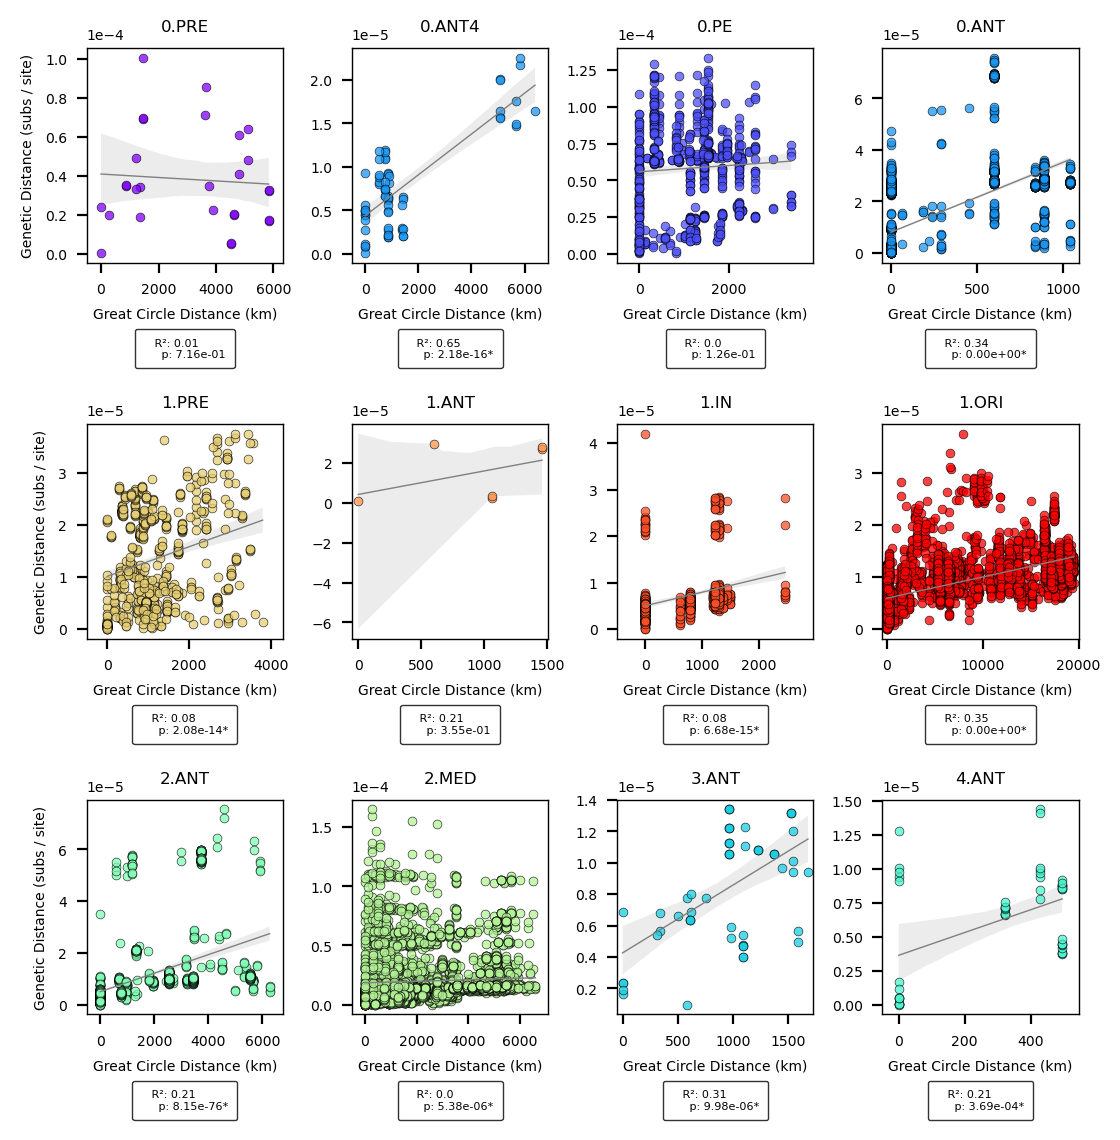

In [131]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=0.75)


i_row = 0
i_col = 0

for label in BRANCH_LIST:
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    
    for branch_major in colors_dict["branch_major"]:
        if branch_major in label:
            break  
            
    # -----------------------
    # Regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ibd_dict[label]["geo_dist"],ibd_dict[label]["genetic_dist"])
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    p_thresh = 0.05    
    if p_value < p_thresh:
        p_sig = "*"
        
    mut_per_year = SEQ_LEN * slope
    year_per_mut = 1 / mut_per_year
    
    reg_dict = {
        "slope": slope,
        "x_intercept" : intercept,
        "y_intercept" : y_intercept,
        "p_value" : p_value,
        "p_sig" : p_sig,
        "year_per_mut" : year_per_mut
    }
    
    sns.regplot(
        ax=ax,
        x=ibd_dict[label]["geo_dist"],
        y=ibd_dict[label]["genetic_dist"],
        ci=95,
        scatter_kws={"s": 0},
        color="grey",
        line_kws={"linewidth":0.5},
        label=(
        "   R²: {}".format(round(r2,2))
        + "\n     p: {:.2e}{}".format(p_value, p_sig)             
        )
    )

    sns.scatterplot(
        ax=ax,
        x=ibd_dict[label]["geo_dist"],
        y=ibd_dict[label]["genetic_dist"],
        s=10,
        ec = "black",
        color = colors_dict["branch_major"][branch_major],         
        alpha=0.75,
        zorder=2,
    )
     
    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.40), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)        
    
    # Set xlimits
    xlim = ax.get_xlim()
    if xlim[1] > 20000:
        xbuff = 5000   
    elif xlim[1] > 2000:
        xbuff = 500
    elif xlim[1] > 200:
        xbuff = 50
    ax.set_xlim(0-xbuff, xlim[1] + xbuff)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Genetic Distance (subs / site)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Great Circle Distance (km)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1

    
out_path = os.path.join(out_dir, "ibd_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Map

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



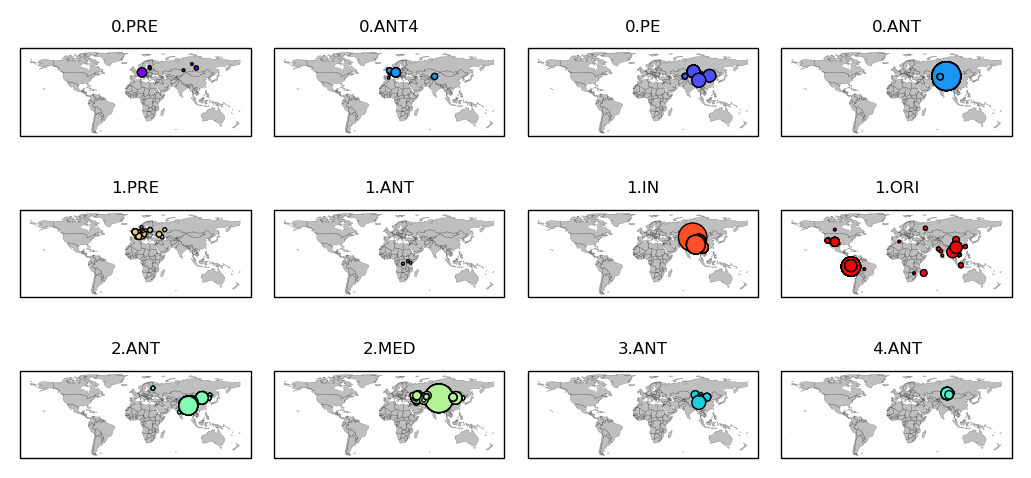

In [132]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

nrow=3
ncol=4

fig, axes = plt.subplots(nrow, ncol, subplot_kw={'projection': CRS_EPSG},
                        figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.1, hspace=-0.75)
i_row = 0
i_col = 0

for label in BRANCH_LIST:
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    
    for branch_major in colors_dict["branch_major"]:
        if branch_major in label:
            break  
    
    # --------------------------------------
    # World Basemap
    world_polygons.plot(
        ax=ax, 
        zorder=1, 
        alpha=0.5, 
        color="grey",
        edgecolor="black", 
        linewidth=0.1,
    ) 

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    df.plot(ax=ax, ec="black", lw=0.5, color=colors_dict["branch_major"][branch_major], markersize=df["geometry_size"], linewidth=0.5)

    # Sorry Antarctica
    ax.set_ylim(-60,90)
    
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)        
    
    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
        
out_path = os.path.join(out_dir, "map_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



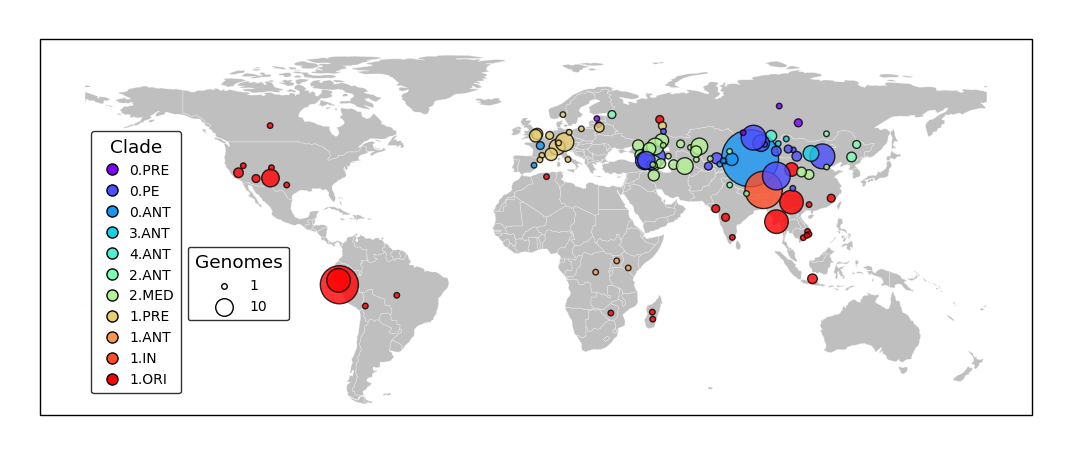

In [133]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=400
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5

## All
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=FIGSIZE, dpi=DPI)
world_polygons.plot(
    ax=ax, 
    zorder=1, 
    alpha=0.5, 
    color="grey",
    edgecolor="white", 
    linewidth=0.1,
) 

reduce_gdf = copy.deepcopy(metadata_gdf)

plotted_coord = []

for rec in metadata_gdf.iterrows():
    sample=rec[0]
    x,y = rec[1]["geometry"].x, rec[1]["geometry"].y
    if [x,y] not in plotted_coord:
        plotted_coord.append([x,y])
    else:
        reduce_gdf.drop(sample, inplace=True)

reduce_gdf.plot(
    ax=ax, 
    ec="black", 
    color=reduce_gdf["branch_major_color"], 
    markersize=reduce_gdf["geometry_size"], 
    linewidth=0.25,
    alpha=0.80,
)

#ax.axis("off")
for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.25)

# Sorry Antarctica
ax.set_ylim(-60,90)

colors_dict_known = copy.copy(colors_dict)
del colors_dict_known["branch_major"][UNKNOWN_CHAR]

clade_lines = [lines.Line2D([0], [0], color=colors_dict_known["branch_major"][state], lw=0, markersize=2, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for state in colors_dict_known["branch_major"]]
clade_labels = [state for state in colors_dict_known["branch_major"]]

clade_legend = fig.legend(clade_lines, 
           clade_labels,
           #ncol=len(clade_labels),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(0.2, 0.475),
           frameon=True,
            borderpad=0.5, 
            handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Clade",
           fontsize=FONTSIZE / 2,
           title_fontsize=FONTSIZE / 1.5,
          )
clade_legend.get_frame().set_linewidth(0.25)

# Size Legend
s = [ax.scatter(0,-9000, s=1, ec="black", c="white", lw=0.25),
     ax.scatter(0,-9000, s=10, ec="black", c="white", lw=0.25),  
    ]
sl = ["1", "10"]
leg_size = plt.legend(s, sl, title="Genomes", loc="center",  borderpad=0.5, bbox_to_anchor=[0.2,0.35], edgecolor="black",
                    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE / 1.5)
leg_size.get_frame().set_linewidth(0.25)

out_path = os.path.join(out_dir, "map_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Modern Human Plague Cases

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'\n# Origin Legend\no = [ax_map.scatter(0,-9000, s=5, ec="black", marker="o", c=D3_PAL[1], lw=0.25),\n     ax_map.scatter(0,-9000, s=5, ec="black", marker="o", c=D3_PAL[0], lw=0.25),\n     ax_map.scatter(0,-9000, s=5, ec="black", marker="o", c=D3_PAL[2], lw=0.25),     \n    ]\nol = ["Ancient Genome", "Modern Genome", "Modern Human Cases"]\n\nleg_origin = plt.legend(\n    o, ol, title="Type", loc="center", bbox_to_anchor=[0.35,-0.15], edgecolor="black",\n    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE - 2)\nleg_origin.get_frame().set_linewidth(0.25)\n\n# Size Legend\ns = [ax_map.scatter(0,-9000, s=1, ec="black", c="black", lw=0.5),\n     ax_map.scatter(0,-9000, s=10, ec="black", c="black", lw=0.5),  \n    ]\nsl = ["1", "10"]\nleg_size = plt.legend(s, sl, title="Genomes", loc="center", bbox_to_anchor=[0.55,-0.15], edgecolor="black",\n                    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE - 2)\nleg_size.get_frame().set_linewidth(0.25)\n\nax_map.add_artist(leg_origin)\n\nout

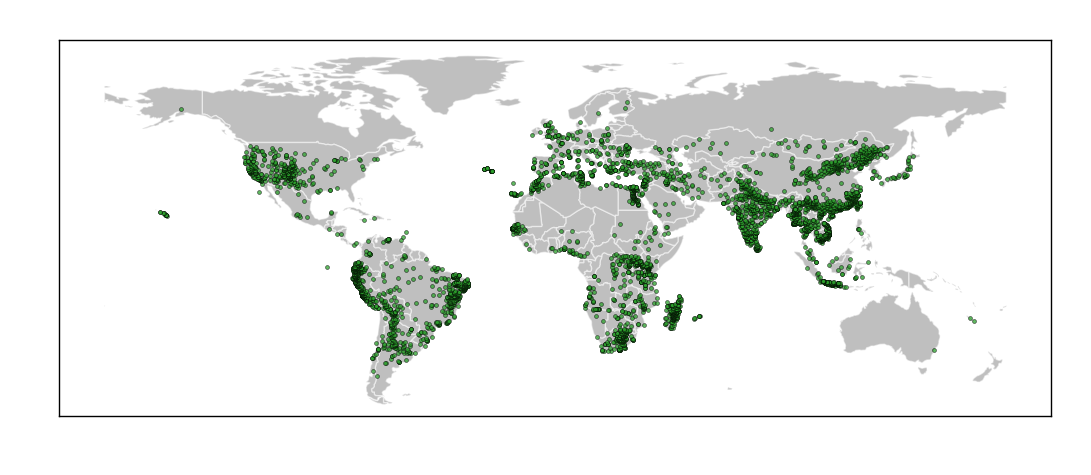

In [134]:
TARGET_RES = [1280, 1280]
DPI=400
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
plt.rc("legend", title_fontsize=MED_FONT)  # fontsize of the legend title
plt.rc("legend", fontsize=MED_FONT)  # fontsize of the legend title

fig, ax = plt.subplots(1, dpi=DPI, figsize=FIGSIZE)
# --------------------------------------
# World Basemap
world_poly = world_polygons.plot(
    ax=ax, 
    zorder=1, 
    alpha=0.5, 
    color="grey",
    edgecolor="white", 
    linewidth=0.25,
)
xu_2019_gdf.plot(ax=ax,  markersize=0.5, alpha=0.75, ec="black", lw=0.1, c=D3_PAL[2])
#ancient_gdf.plot(ax=ax_map,  markersize=ancient_gdf["geometry_size"], alpha=0.75, ec="black", lw=0.25, c=D3_PAL[1])
#modern_gdf.plot(ax=ax_map,  markersize=modern_gdf["geometry_size"], alpha=0.75, ec="black", lw=0.25, c=D3_PAL[0])
# Sorry Antarctica
ax.set_ylim(-60,90)
#ax_map.axis('off')  
for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.25)
ax.set_xticks([])
ax.set_yticks([])

out_path = os.path.join(out_dir, "map_xu-2019")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")
"""
# Origin Legend
o = [ax_map.scatter(0,-9000, s=5, ec="black", marker="o", c=D3_PAL[1], lw=0.25),
     ax_map.scatter(0,-9000, s=5, ec="black", marker="o", c=D3_PAL[0], lw=0.25),
     ax_map.scatter(0,-9000, s=5, ec="black", marker="o", c=D3_PAL[2], lw=0.25),     
    ]
ol = ["Ancient Genome", "Modern Genome", "Modern Human Cases"]

leg_origin = plt.legend(
    o, ol, title="Type", loc="center", bbox_to_anchor=[0.35,-0.15], edgecolor="black",
    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE - 2)
leg_origin.get_frame().set_linewidth(0.25)

# Size Legend
s = [ax_map.scatter(0,-9000, s=1, ec="black", c="black", lw=0.5),
     ax_map.scatter(0,-9000, s=10, ec="black", c="black", lw=0.5),  
    ]
sl = ["1", "10"]
leg_size = plt.legend(s, sl, title="Genomes", loc="center", bbox_to_anchor=[0.55,-0.15], edgecolor="black",
                    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE - 2)
leg_size.get_frame().set_linewidth(0.25)

ax_map.add_artist(leg_origin)

out_path = os.path.join(out_dir, "map_comparison")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""